In [2]:
# Mount Google Drive to access the dataset stored in 'eye_diseases' folder
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


Mounted at /content/drive


In [3]:
# Path to the dataset in Google Drive
data_dir = '/content/drive/MyDrive/eye_disease_dataset'

# Define ImageDataGenerators for training, validation, and test sets
# Data augmentation for training: rotation, zoom, and flip
# Train/Validation split: 90% train, 10% validation of 90% split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1  # 90% for training, 10% for validation of the total 90%
)

# Test set does not require augmentation, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Training generator (80% of the data)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Training data (50% of 20%)
)

# Validation generator (10% of the data)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Validation data (50% of 20%)
)

# Test generator (10% of the data)
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No shuffling for test data
)

Found 3798 images belonging to 4 classes.
Found 419 images belonging to 4 classes.
Found 4217 images belonging to 4 classes.


In [5]:
# Load ResNet50 model pre-trained on ImageNet, without the top layer (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for our 4-class problem
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling instead of flattening
x = Dense(1024, activation='relu')(x)  # Fully connected layer with ReLU activation
predictions = Dense(4, activation='softmax')(x)  # Output layer for 4 classes with softmax

# Create the final model by combining the base and custom layers
model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Compile the model with Adam optimizer and a low learning rate for transfer learning
model.compile(optimizer=Adam(learning_rate=0.0001),  # Low learning rate for fine-tuning
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])  # Track accuracy as the metric


In [7]:
# Train the model
history = model.fit(
    train_generator,  # Training data generator
    epochs=10,  # Number of epochs
    validation_data=validation_generator,  # Validation data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Steps per epoch
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Validation steps
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


118/118 ━━━━━━━━━━━━━━━━━━━━ 3764s 31s/step - accuracy: 0.7366 - loss: 0.6313 - val_accuracy: 0.2476 - val_loss: 1.9912
Epoch 2/10
  1/118 ━━━━━━━━━━━━━━━━━━━━ 57:02 29s/step - accuracy: 0.9688 - loss: 0.1781

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


118/118 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.9688 - loss: 0.1781 - val_accuracy: 0.0000e+00 - val_loss: 3.2694
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3528s 30s/step - accuracy: 0.9192 - loss: 0.2222 - val_accuracy: 0.2452 - val_loss: 2.1105
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8125 - loss: 0.3840 - val_accuracy: 0.3333 - val_loss: 1.5854
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3482s 29s/step - accuracy: 0.9357 - loss: 0.1777 - val_accuracy: 0.2428 - val_loss: 2.4370
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 56s 237ms/step - accuracy: 0.9062 - loss: 0.2277 - val_accuracy: 0.6667 - val_loss: 1.2238
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3500s 30s/step - accuracy: 0.9526 - loss: 0.1315 - val_accuracy: 0.2500 - val_loss: 2.4486
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9688 - loss: 0.0630 - val_accuracy: 0.0000e+00 - val_loss: 3.1161
Epoch 9/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 3566s 30s/step - accuracy: 0.9577 - loss: 0.1032 - v

In [8]:
# Evaluate the model on the test set and print test accuracy
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


131/131 ━━━━━━━━━━━━━━━━━━━━ 903s 7s/step - accuracy: 0.5886 - loss: 2.6522
Test Accuracy: 24.83%


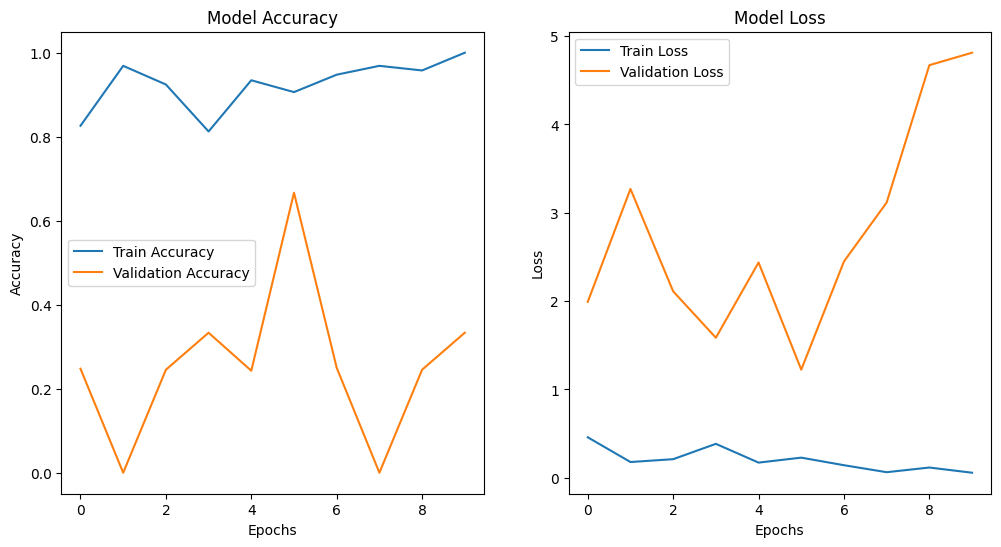

In [9]:
# Plot training and validation accuracy and loss curves
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [10]:
# Predict on test data
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class labels

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class names

# Classification report
print('Classification Report')
print(classification_report(true_classes, y_pred, target_names=class_labels))

# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(true_classes, y_pred))


132/132 ━━━━━━━━━━━━━━━━━━━━ 891s 7s/step
Classification Report
                      precision    recall  f1-score   support

            cataract       0.25      1.00      0.40      1038
diabetic_retinopathy       1.00      0.00      0.01      1098
            glaucoma       0.00      0.00      0.00      1007
              normal       0.00      0.00      0.00      1074

            accuracy                           0.25      4217
           macro avg       0.31      0.25      0.10      4217
        weighted avg       0.32      0.25      0.10      4217

Confusion Matrix
[[1038    0    0    0]
 [1095    3    0    0]
 [1007    0    0    0]
 [1074    0    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
